In [1]:
from get_dataset import * 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers
import seaborn as sns

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-19 17:48:36.788734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
def my_map(x, y):
    return x[..., tf.newaxis], y

ds_train = get_dataset("train").map(my_map).batch(64)
ds_test = get_dataset("test").map(my_map).batch(64)

2023-04-19 17:48:46.773772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7624 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [25]:
model = models.Sequential([
    layers.Input(shape=[124, 129, 1]),
    layers.Resizing(32, 64),
    layers.Conv2D(32, 3, activation='gelu'),
    layers.Conv2D(32, 4, activation='gelu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='gelu'),
    layers.Dropout(0.5),
    layers.Dense(12),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_11 (Resizing)      (None, 32, 64, 1)         0         
                                                                 
 conv2d_22 (Conv2D)          (None, 30, 62, 32)        320       
                                                                 
 conv2d_23 (Conv2D)          (None, 27, 59, 32)        16416     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 13, 29, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 13, 29, 32)        0         
                                                                 
 flatten_11 (Flatten)        (None, 12064)             0         
                                                     

In [26]:
EPOCHS = 30
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/30


2023-04-19 18:03:53.332813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


348/348 [==============================] - 3s 5ms/step - loss: 1.3948 - accuracy: 0.5323 - val_loss: 0.9507 - val_accuracy: 0.6728
Epoch 2/30
348/348 [==============================] - 2s 5ms/step - loss: 0.8139 - accuracy: 0.7285 - val_loss: 0.7189 - val_accuracy: 0.7585
Epoch 3/30
348/348 [==============================] - 2s 5ms/step - loss: 0.6226 - accuracy: 0.7903 - val_loss: 0.6633 - val_accuracy: 0.7838
Epoch 4/30
348/348 [==============================] - 2s 5ms/step - loss: 0.5147 - accuracy: 0.8289 - val_loss: 0.5739 - val_accuracy: 0.8085
Epoch 5/30
348/348 [==============================] - 2s 5ms/step - loss: 0.4578 - accuracy: 0.8459 - val_loss: 0.5665 - val_accuracy: 0.8156
Epoch 6/30
348/348 [==============================] - 2s 5ms/step - loss: 0.4154 - accuracy: 0.8578 - val_loss: 0.5490 - val_accuracy: 0.8238
Epoch 7/30
348/348 [==============================] - 2s 5ms/step - loss: 0.3666 - accuracy: 0.8754 - val_loss: 0.5482 - val_accuracy: 0.8309
Epoch 8/30
348/34

49/49 [==============================] - 0s 2ms/step


2023-04-19 18:04:26.128101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


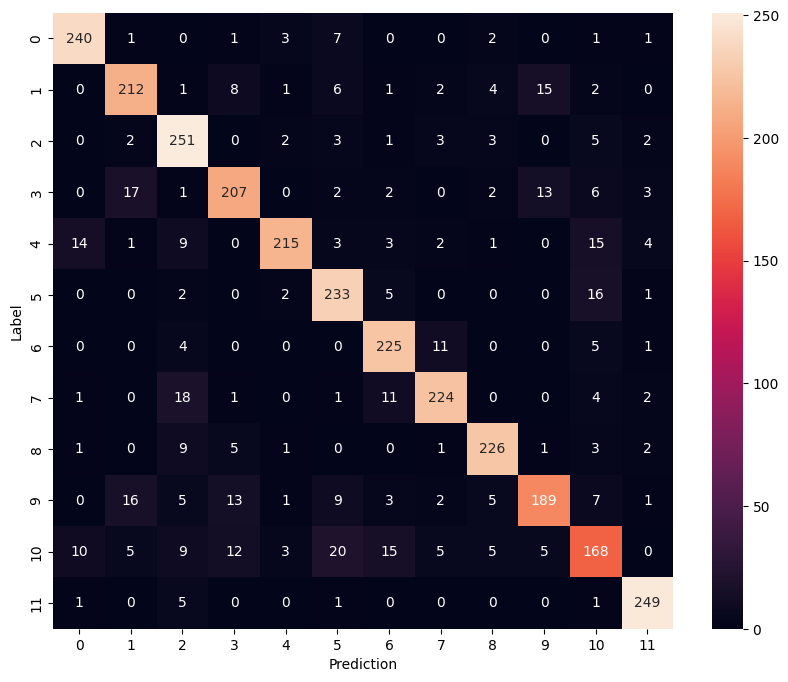

In [27]:
y_pred = model.predict(ds_test)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(ds_test.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
